# Lab 1: Learned Index Structure

In this lab, we will implement a 2-stage recursive model index (RMI) as a replacement for conventional B-tree index structures.
![recursive model index](./rmi.png)

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

1.10.1


In [2]:
def plot_histogram(x):
    plt.figure()
    plt.title('Histogram')
    plt.xlabel('Key')
    plt.ylabel('# of Occurence')
    plt.hist(x, bins=20)
    plt.show()

In [3]:
def generate_lognormal_data(mean=0.0, sigma=2.0, size=250000):
    x = np.random.lognormal(mean=mean, sigma=sigma, size=size)
    scale = 2000000 / np.amax(x)
    x = x * scale
    x = x.astype(np.int64)
    x = np.unique(x)
    n = len(x)
    print('Lognormal distribution: {} unique keys generated.'.format(n))
    return n, x

In [4]:
def generate_normal_data(loc=0.0, scale=1.0, size=25000):
    x = np.random.normal(loc=loc, scale=scale, size=size)
    x = np.clip(x, 0, None)
    scale = 1000000 / np.amax(x)
    x = x * scale
    x = x.astype(np.int64)
    x = np.unique(x)
    n = len(x)
    print('Normal distribution: {} unique keys generated.'.format(n))
    return n, x

In [5]:
def generate_real_data():
    import csv
    import datetime
    import time

    with open('nasa-100k.log') as csvfile:
        rows = csv.reader(csvfile, delimiter=' ')
        x = [time.mktime(datetime.datetime.strptime(row[3][1:], "%d/%b/%Y:%X").timetuple()) for row in rows]

    x = np.array(x)
    x.astype(np.int64)
    n = len(x)
    print('Real data: {} unique keys generated.'.format(n))
    return n, x

In [6]:
def obtain_labels(x):
    y = np.argsort(x)
    y = np.argsort(y)
    return y

In [7]:
def evalute_min_max_error(golden, pred):
    error = pred - golden
    print('min error = {}'.format(np.min(error)))
    print('max error = {}'.format(np.max(error)))

## Generate keys

Call `generate_log_normal_data` or `generate_normal_data` to generate synthetic data points.

Call `generate_real_data` to generate real-world data points.

The keys are stored in an 1-D integer array `x` of size `n`.

The histogram of `x` is shown in the following histogram.

Lognormal distribution: 10163 unique keys generated.


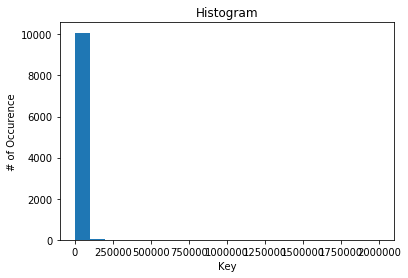

In [8]:
n, x = generate_lognormal_data()
#n, x = generate_normal_data()
#n, x = generate_real_data()
plot_histogram(x)

## Prepare training pairs

The label of each data point is essentially the position of the key.

In [9]:
y = obtain_labels(x)
x = np.expand_dims(x, 1)
print(x.shape)

(10163, 1)


## Build and train the first-stage model

In [10]:
model = keras.Sequential([
    keras.layers.Dense(32, activation=tf.nn.relu),
    keras.layers.Dense(1)
])
model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='mean_squared_error')
history = model.fit(x, y, epochs=10, batch_size=1000)

Epoch 1/10
10163/10163 [==============================] - 0s 31us/step - loss: 61788290.3456
Epoch 2/10
10163/10163 [==============================] - 0s 4us/step - loss: 45640043.6979
Epoch 3/10
10163/10163 [==============================] - 0s 3us/step - loss: 40930230.6948
Epoch 4/10
10163/10163 [==============================] - 0s 3us/step - loss: 32492383.7979
Epoch 5/10
10163/10163 [==============================] - 0s 3us/step - loss: 29816427.1390
Epoch 6/10
10163/10163 [==============================] - 0s 3us/step - loss: 28948556.1494
Epoch 7/10
10163/10163 [==============================] - 0s 3us/step - loss: 27399376.1836
Epoch 8/10
10163/10163 [==============================] - 0s 3us/step - loss: 27085617.7436
Epoch 9/10
10163/10163 [==============================] - 0s 3us/step - loss: 27160789.9010
Epoch 10/10
10163/10163 [==============================] - 0s 3us/step - loss: 26886969.0975


## Display the training process

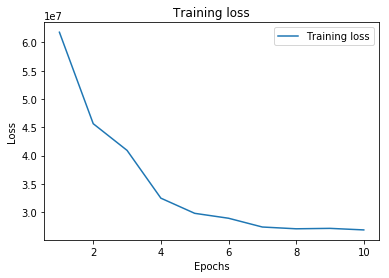

In [11]:
loss = history.history['loss']

epochs = range(1, len(loss) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Make prediction with the first-stage model

In [12]:
pred_first = model.predict(x)
pred_first = pred_first.flatten().astype(np.int64)
print(pred_first.shape)

(10163,)


## Evaluate the intermediate results

In [13]:
evalute_min_max_error(y, pred_first)

min error = -7328
max error = 165482


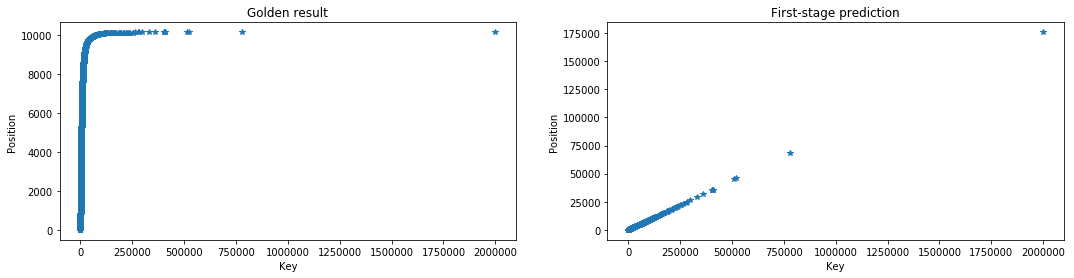

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(18, 4))
axes[0].set_title('Golden result')
axes[0].set_xlabel('Key')
axes[0].set_ylabel('Position')
axes[0].plot(x, y, linestyle='None', marker='*')
axes[1].set_title('First-stage prediction')
axes[1].set_xlabel('Key')
axes[1].set_ylabel('Position')
axes[1].plot(x, pred_first, linestyle='None', marker='*')
plt.show()

## Distribute data points into buckets

Assign data points into different buckets based on the predictions of the first-stage model.

The `sel_model` is an array of size equal to the number of data points. Each element in `sel_model` represents the "bucket" (i.e., second-stage model) to which its corresponding data point belongs.

In [15]:
n_second_stage_model = 10
sel_model = pred_first.astype(np.float64) / n * n_second_stage_model
sel_model = sel_model.astype(np.int64)
sel_model = np.clip(sel_model, 0, n_second_stage_model - 1)
print(sel_model.shape)
x_bucket = []
y_bucket = []
for m in range(n_second_stage_model):
    x_bucket.append(x[np.where(sel_model == m)])
    y_bucket.append(y[np.where(sel_model == m)])
print(map(len, x_bucket))

(10163,)
[7894, 1389, 390, 157, 100, 68, 39, 33, 17, 76]


## Train the second-stage models

In [16]:
wts = []
bss = []
for m in range(n_second_stage_model):
    wt, bs = (0, 0)
    if len(x_bucket[m] != 0):
        wt, bs = np.polyfit(x_bucket[m].flatten(), y_bucket[m], 1)
        print(wt, bs)
    wts.append(wt)
    bss.append(bs)

(0.7432285650270433, 619.7793795022442)
(0.12359174328520053, 6611.337544773161)
(0.03375483927374619, 8527.275309183064)
(0.01397721736358242, 9193.322114141802)
(0.008148056181341472, 9456.781208248294)
(0.005946804730571549, 9586.040037490628)
(0.0036003137312007843, 9746.254284151755)
(0.0029269730316378332, 9800.228294214652)
(0.0016388833806870947, 9917.723953712135)
(5.191115286886605e-05, 10113.041581557025)


## Show the data points in each bucket

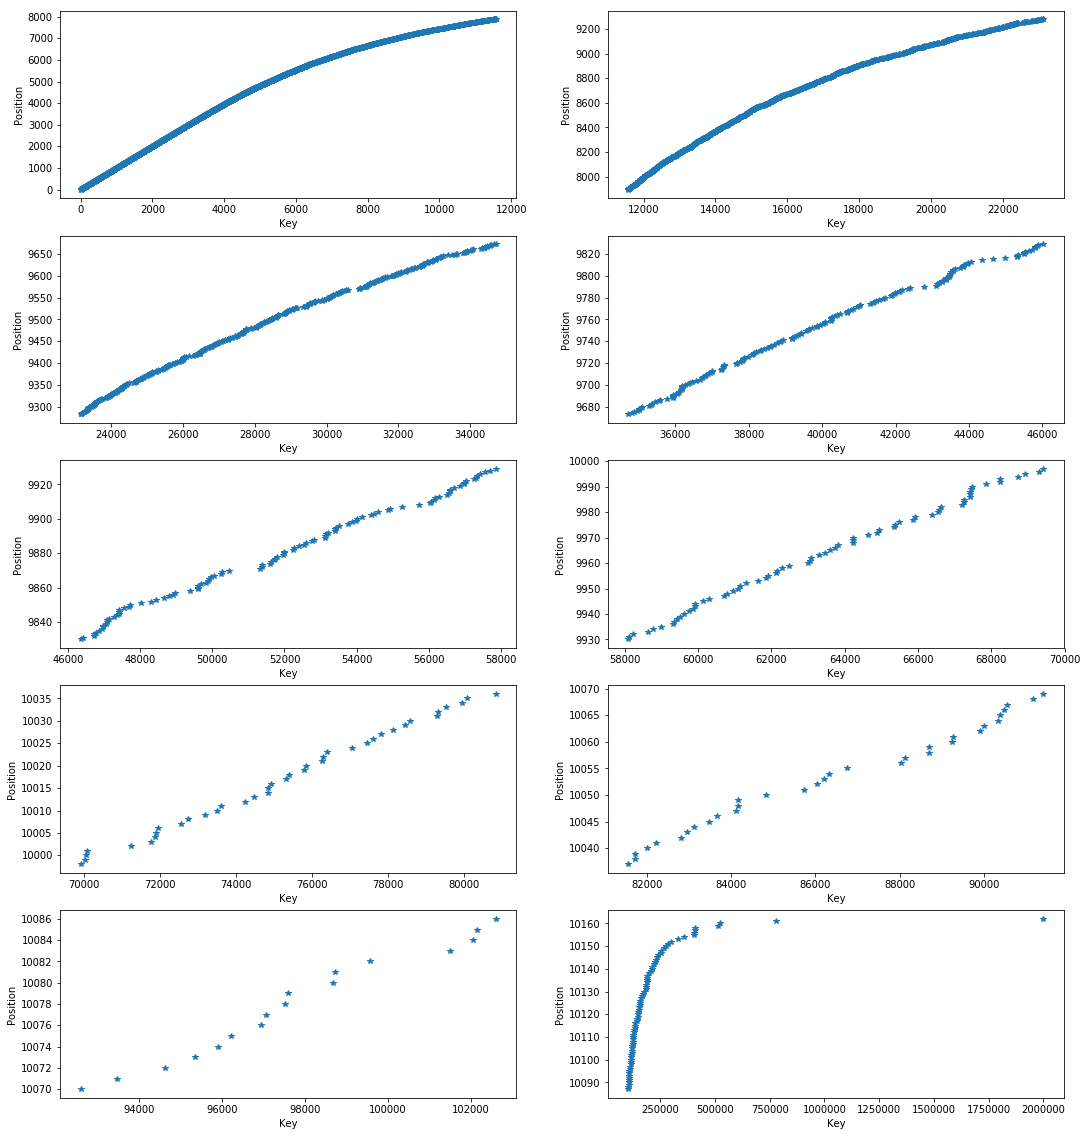

In [17]:
fig, axes = plt.subplots(n_second_stage_model / 2, 2, figsize=(18, n_second_stage_model * 2))
print(axes[0])
for idx in range(n_second_stage_model):
    axes[idx / 2, idx % 2].set_xlabel('Key')
    axes[idx / 2, idx % 2].set_ylabel('Position')
    axes[idx / 2, idx % 2].plot(x_bucket[idx], y_bucket[idx], linestyle='None', marker='*')
plt.show()

## Make predictions with the 2-stage RMI

In [18]:
pred_second = np.array([])
for i in range(n):
    pred_second = np.append(pred_second, (wts[sel_model[i]] * x[i] + bss[sel_model[i]]))
pred_second = pred_second.astype(np.int64)

## Evaluate the final results

In [19]:
print('First-stage:')
evalute_min_max_error(y, pred_first)
print('Second-stage:')
evalute_min_max_error(y, pred_second)

First-stage:
min error = -7328
max error = 165482
Second-stage:
min error = -478
max error = 1323


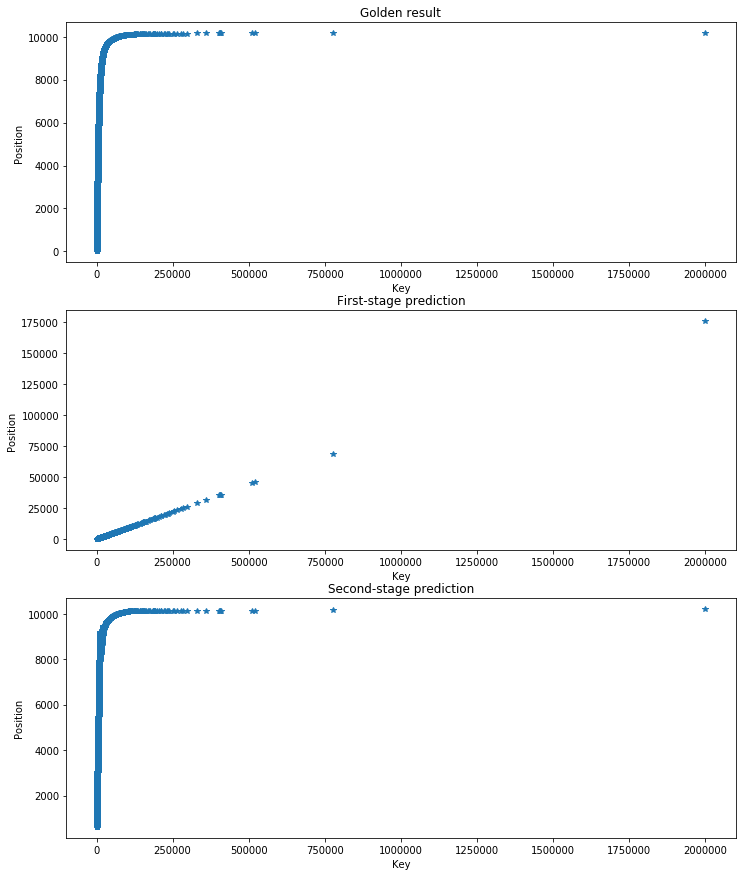

In [20]:
fig, axes = plt.subplots(3, 1, figsize=(12, 15))
axes[0].set_title('Golden result')
axes[0].set_xlabel('Key')
axes[0].set_ylabel('Position')
axes[0].plot(x, y, linestyle='None', marker='*')
axes[1].set_title('First-stage prediction')
axes[1].set_xlabel('Key')
axes[1].set_ylabel('Position')
axes[1].plot(x, pred_first, linestyle='None', marker='*')
axes[2].set_title('Second-stage prediction')
axes[2].set_xlabel('Key')
axes[2].set_ylabel('Position')
axes[2].plot(x, pred_second, linestyle='None', marker='*')
plt.show()